<a href="https://colab.research.google.com/github/VikramjitSinghRathee/RDKit-Cheminformatics/blob/master/Pandas_with_RDKit_and_Javascript_d3js.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install RDKit. Takes 2-3 minutes
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

--2020-05-26 02:41:44--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh [following]
--2020-05-26 02:41:45--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - \ | / - \ | / - done

## Package Plan ##

  environment 

In [2]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs
import numpy as np

# import pandas and related libraries
import pandas as pd
from rdkit.Chem import PandasTools

# import mpld3 for d3js use
! python -m pip install mpld3
sys.path.append('/root/.local/lib/python3.7/site-packages/')
from rdkit.Chem.Draw import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
import matplotlib.pyplot as plt
import mpld3
from mpld3 import plugins
mpld3.enable_notebook()

print("Done")

Done


In [3]:
# Get solubility data from github
%%bash
wget https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv

--2020-05-26 02:44:56--  https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96699 (94K) [text/plain]
Saving to: ‘delaney-processed.csv.3’

     0K .......... .......... .......... .......... .......... 52% 3.45M 0s
    50K .......... .......... .......... .......... ....      100% 14.7M=0.02s

2020-05-26 02:44:57 (5.39 MB/s) - ‘delaney-processed.csv.3’ saved [96699/96699]



In [4]:
# creating a dataframe with smiles string
data = pd.read_csv('delaney-processed.csv')
data = data[['Compound ID', 'smiles','measured log solubility in mols per litre']]
data

,Compound ID,smiles,measured log solubility in mols per litre
0,Amigdalin,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,-0.770
1,Fenfuram,Cc1occc1C(=O)Nc2ccccc2,-3.300
2,citral,CC(C)=CCCC(C)=CC(=O),-2.060
3,Picene,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-7.870
4,Thiophene,c1ccsc1,-1.330
...,...,...,...
1123,halothane,FC(F)(F)C(Cl)Br,-1.710
1124,Oxamyl,CNC(=O)ON=C(SC)C(=O)N(C)C,0.106
1125,Thiometon,CCSCCSP(=S)(OC)OC,-3.091
1126,2-Methylbutane,CCC(C)C,-3.180


,Compound ID,smiles,measured log solubility in mols per litre,Molecule
0,Amigdalin,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,-0.77,
1,Fenfuram,Cc1occc1C(=O)Nc2ccccc2,-3.30,
2,citral,CC(C)=CCCC(C)=CC(=O),-2.06,
3,Picene,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-7.87,
4,Thiophene,c1ccsc1,-1.33,

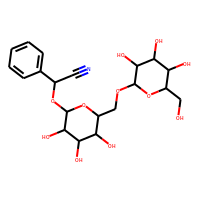
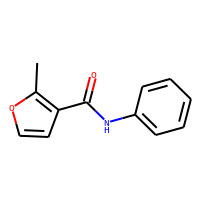
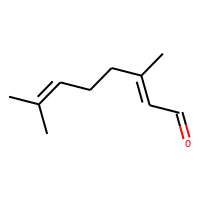
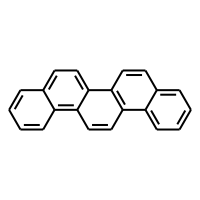
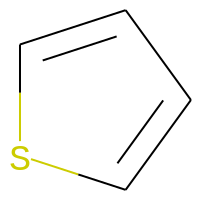

In [5]:
# Include a new column into the dataframe that shows the shape of the molecule using RDKit
PandasTools.AddMoleculeColumnToFrame(data,'smiles','Molecule')
data.head()

,Compound ID,smiles,measured log solubility in mols per litre,Molecule,Molecular Weight
0,Amigdalin,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,-0.77,,457.432
1,Fenfuram,Cc1occc1C(=O)Nc2ccccc2,-3.30,,201.225
2,citral,CC(C)=CCCC(C)=CC(=O),-2.06,,152.237
3,Picene,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-7.87,,278.354
4,Thiophene,c1ccsc1,-1.33,,84.143

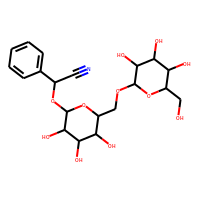
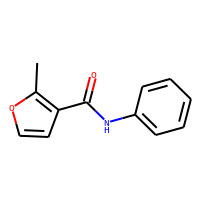
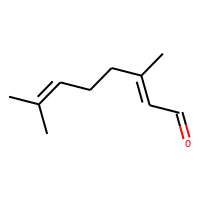
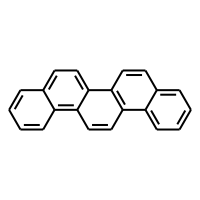
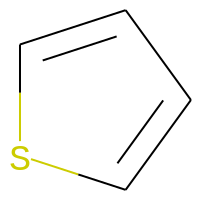

In [6]:
# Molecule column contains not just picture but there is molecule hiding behind it and so can get info about the molecule using RDKit
data['Molecular Weight'] = [Descriptors.MolWt(mol) for mol in data['Molecule']]
data.head()

# Using d3js javascript to plot the chemical space

In [0]:
def moltosvg(mol,molSize=(225,75),kekulize=True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return svg.replace('svg:','')

In [0]:
# using 5 smiles string from the data frame
smiles_list = data['smiles'].head()
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]

# using data from the dataframe for plotting
plot_data_X =  data['Molecular Weight'].head()
plot_data_Y =  data['measured log solubility in mols per litre'].head()

svgs = [moltosvg(m) for m in mols]

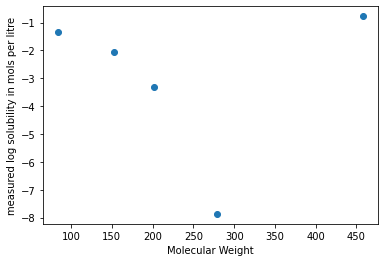

In [9]:
# interactive figure which shows the corresponding shape of the molecule when the cursor is hovered over the data point
fig, ax = plt.subplots()
ax.set_xlabel('Molecular Weight')
ax.set_ylabel('measured log solubility in mols per litre')
points = ax.scatter(plot_data_X , plot_data_Y)
tooltip = plugins.PointHTMLTooltip(points, svgs)
plugins.connect(fig, tooltip)